# 10. 트랜스포머로 만드는 대화형 챗봇 [프로젝트]

## 10-1. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [107]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)

2.13.0


### Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

songys/Chatbot_data

https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

Cloud shell에서 아래 명령어를 입력해 주세요.

```bash
!mkdir -p aiffel/transformer_chatbot/data/
!ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

## Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [108]:
def preprocess_text(text):
    # 문장부호 앞에 공백 추가
    text = re.sub(r"([?.!,])", r" \1 ", text)
    # ".,!?"를 제외한 모든 문자를 공백으로 대체
    text = re.sub(r' +', " ", text)
    return text

def preprocess_csv_file(input_path, output_path):
    # CSV 파일을 DataFrame으로 불러오기
    data = pd.read_csv(input_path)
    
    # 'Q'와 'A' 열에 대해 전처리 함수 적용
    data['Q'] = data['Q'].apply(preprocess_text)
    data['A'] = data['A'].apply(preprocess_text)

    # 'label' 열 삭제
    data = data.drop(columns=['label'])
    
    # 전처리된 데이터를 CSV 파일로 저장
    data.to_csv(output_path, index=False)

# 파일 경로:
input_filepath = 'aiffel/transformer_chatbot/data/ChatbotData.csv'
output_filepath = 'aiffel/transformer_chatbot/preprocessed/ChatbotData.csv'
preprocess_csv_file(input_filepath, output_filepath)

In [109]:
def load_conversations():
    # 전처리된 CSV 파일 불러오기
    data = pd.read_csv(output_filepath, usecols=['Q', 'A'])
    return data['Q'].tolist(), data['A'].tolist()

questions, answers = load_conversations()

print('Total number of samples (questions):', len(questions))
print('Total number of samples (answers):', len(answers))

Total number of samples (questions): 11823
Total number of samples (answers): 11823


In [110]:
# 임의로 22번째 샘플을 출력해서 전처리 함수 작동 확인 및 병렬처리 확인
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 . 


## Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [111]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [112]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [113]:
# 시작 토큰과 종료 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [114]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [115]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5761, 609, 2489, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 7, 6273, 96, 1]


In [116]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [117]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [118]:
# 단어장 크기 및 필터링 후의 샘플 수 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [119]:
# 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성
# 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")
슝=3

슝=3


## Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [120]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [121]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [122]:
# 멀티 헤드 어텐션 구현

# 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        
        # 어텐션의 머리 수를 정의합니다
        self.num_heads = num_heads
        
        # 모델의 깊이 (즉, 임베딩 벡터의 차원)를 정의합니다
        self.d_model = d_model
        
        # d_model이 num_heads로 나누어 떨어져야 합니다.
        # 이는 각 머리가 동일한 크기를 가져야 한다는 것을 의미합니다.
        assert d_model % self.num_heads == 0
        
        # 각 머리의 깊이를 정의합니다
        self.depth = d_model // self.num_heads
        
        # Q, K, V에 대한 선형 변환을 위한 Dense 레이어를 정의합니다
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        # 최종 출력에 대한 선형 변환을 위한 Dense 레이어를 정의합니다
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        # 입력을 여러 머리로 분할하는 함수입니다
        # inputs의 형태를 변경하고, 머리를 분할하여 병렬로 처리할 수 있게 합니다
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # 어텐션 연산을 수행하는 메서드입니다
        
        # Q, K, V 및 마스크를 입력에서 추출합니다
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 대한 Dense 변환을 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 입력을 여러 머리로 분할합니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수를 적용합니다
        # 이 함수는 여기에 표시되지 않았지만, 어딘가에 정의되어 있어야 합니다
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        # 어텐션 결과를 원래의 형태로 되돌립니다
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 모든 머리의 결과를 연결합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에 Dense 변환을 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

print("슝=3")


슝=3


In [123]:
#  패딩 마스킹을 구현하는 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [124]:
# 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [125]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [126]:
# 인코더 층을 쌓아 인코더 만들기

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [127]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [128]:
#인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다.
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [129]:
from tensorflow.keras.regularizers import l2

# 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])


  # L2 regularization strength
  l2_strength = 1e-4
  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, kernel_regularizer=l2(l2_strength), name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [130]:
## 모델생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 256)            3146240   ['inputs[0][0]',              
                                                                     'enc_padding_mask[0

In [131]:
# 손실 함수(Loss function)
def loss_function(y_true, y_pred):
  # y_true의 shape을 (-1, MAX_LENGTH - 1)로 변경
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  # SparseCategoricalCrossentropy 손실 함수 정의
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  # 패딩 부분에 대한 손실 제거
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  # 전체 손실 평균 계산
  return tf.reduce_mean(loss)

In [132]:
# 커스텀 된 학습률(Learning rate)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    사용자 정의 학습률 스케줄링 클래스. 
    트랜스포머의 학습률 스케줄링 방식을 구현합니다.
    """

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        # 모델의 깊이 (즉, 임베딩 벡터의 차원)를 저장합니다
        self.d_model = d_model
        # d_model을 float32로 명시적으로 형변환합니다
        self.d_model = tf.cast(self.d_model, tf.float32)

        # warmup_steps: 학습 초기에 학습률을 점진적으로 증가시키는 단계의 수
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """
        주어진 학습 스텝에 대한 학습률을 계산합니다.
        """
        # step을 float32로 형변환합니다
        step = tf.cast(step, tf.float32)  

        # arg1: 학습 스텝의 역제곱근
        arg1 = tf.math.rsqrt(step)
        # arg2: 학습 스텝과 warmup_steps의 관계에 따라 조정된 값
        arg2 = step * (self.warmup_steps**-1.5)

        # 최종 학습률은 d_model의 역제곱근과 arg1, arg2 중 작은 값의 곱으로 계산됩니다
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

print("슝=3")


슝=3


Text(0.5, 0, 'Train Step')

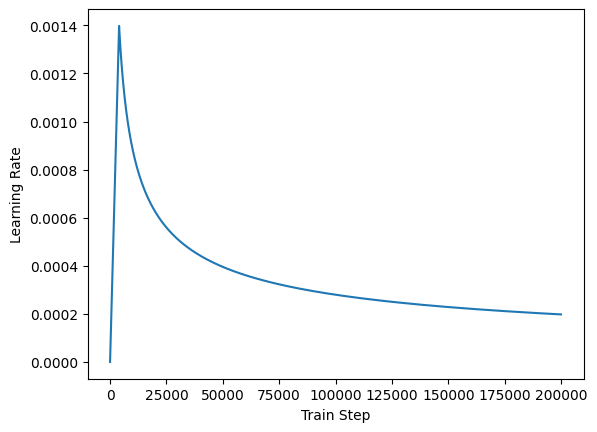

In [133]:
# 커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [134]:
# D_MODEL은 모델의 깊이 (즉, 임베딩 벡터의 차원)를 나타냅니다. 
# CustomSchedule을 사용하여 학습률 스케줄링을 설정합니다.
learning_rate = CustomSchedule(D_MODEL)

# Adam 최적화기를 초기화합니다. 
# CustomSchedule로부터 얻은 학습률과 다른 하이퍼파라미터들을 사용합니다.
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 사용자 정의 정확도 함수를 정의합니다.
# 이 함수는 y_true의 형태를 변경하고, 
# sparse_categorical_accuracy 메트릭을 사용하여 정확도를 계산합니다.
def accuracy(y_true, y_pred):
  # y_true의 형태를 변경합니다.
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델을 컴파일합니다.
# 위에서 정의한 Adam 최적화기와 사용자 정의 손실 함수 및 정확도 함수를 사용합니다.
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

print("슝=3")


슝=3


In [135]:
# 훈련하기(학습 진행)
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30


185/185 [==============================] - 34s 117ms/step - loss: 1.4991 - accuracy: 0.0297
Epoch 2/30
185/185 [==============================] - 11s 60ms/step - loss: 1.2266 - accuracy: 0.0500
Epoch 3/30
185/185 [==============================] - 10s 53ms/step - loss: 1.0516 - accuracy: 0.0511
Epoch 4/30
185/185 [==============================] - 10s 53ms/step - loss: 0.9777 - accuracy: 0.0545
Epoch 5/30
185/185 [==============================] - 10s 51ms/step - loss: 0.9257 - accuracy: 0.0576
Epoch 6/30
185/185 [==============================] - 10s 52ms/step - loss: 0.8771 - accuracy: 0.0611
Epoch 7/30
185/185 [==============================] - 10s 52ms/step - loss: 0.8251 - accuracy: 0.0658
Epoch 8/30
185/185 [==============================] - 9s 49ms/step - loss: 0.7693 - accuracy: 0.0718
Epoch 9/30
185/185 [==============================] - 9s 50ms/step - loss: 0.7112 - accuracy: 0.0786
Epoch 10/30
185/185 [==============================] - 10s 56ms/step - loss: 0.6534 - accuracy

## Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [136]:
# 예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

# 1.새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
# 2.입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
# 3.패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
# 4.디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
# 5.디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
# 6.END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.
# 위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

def decoder_inference(sentence):
  sentence = preprocess_text(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [137]:
#임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [138]:
sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요 . 


'안녕하세요 . '

In [143]:
sentence_generation("가스비 너무 비싸")


입력 : 가스비 너무 비싸
출력 : 다음 달에는 더 절약해봐요 . 


'다음 달에는 더 절약해봐요 . '

In [145]:
sentence_generation("나랑 놀자")


입력 : 나랑 놀자
출력 : 같이 놀아요 . 


'같이 놀아요 . '

In [146]:
sentence_generation("나만 갈궈")


입력 : 나만 갈궈
출력 : 애정표현일 지도 몰라요 . 


'애정표현일 지도 몰라요 . '

In [147]:
sentence_generation("배고파")


입력 : 배고파
출력 : 얼른 맛난 음식 드세요 . 


'얼른 맛난 음식 드세요 . '

# 회고
전체적으로 코드를 뜯어보기에 너무 어렵고 처음보는 코드들이 많아 당황스러웠지만
트랜스포머 모델의 전체 구조나 개념을 익힐수 있는 시간이었다.

위 모델의 성능향상을 위해 처음 해본것은 EPoch을 늘려보는 것이었다.
확실히 10일때보다 대답의 정확도가 올라간 것을 체감할수 있었다. 


과적합 방지 및 성능 개선을 위하여
L2 규제 추가, EPOCH 30으로 변경 진행

성능 개선을 위한 향후 개선 적용 사항 List up

1. 데이터 확장: 추가 데이터를 사용하여 모델을 학습
2. 모델 구조 조정: 레이어의 수, 차원 수, 헤드 수 등의 하이퍼파라미터를 조정하여 성능을 향상
3. 정규화 기법: 드롭아웃 외에도 L1, L2 정규화나 배치 정규화 등의 기법을 사용하여 과적합을 방지하고 성능을 향상
4. 다른 최적화 도구: Adam 외의 다른 최적화 도구를 시도
5. 학습률 스케줄링 조정: 초기 학습률, 최대 학습률 등의 하이퍼파라미터를 조정하여 학습률 스케줄링을 최적화
